# THE WORK BELOW REFERS TO 2 SOURCES OF CODE SAMPLE:
1. Sample loading: TensorFlow 2018: 
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb

2. Topic modelling:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


# Purpose: Find optimal topic for 1000, 9000 & 13000 samples

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
import tensorflow as tf
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 331s 0us/step


In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

# 1000 samples

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.Random(42).shuffle(image_paths)

# Select the first 1000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 5,000 examples.
train_image_paths = image_paths [:1000]
print(len(train_image_paths))

1000


In [ ]:
import pandas as pd
caption_table=pd.DataFrame(list())
caption_table['image_path']=train_image_paths
caption_table['text']=['']*1000
caption_table['image_path'][0]

'/content/train2014/COCO_train2014_000000521200.jpg'

In [ ]:
# create dataframe to store image path, with ALL CAPTION MERGED
for i in range(1000):
    caption_table['text'][i]= image_path_to_caption[caption_table['image_path'][i]][0][8:-6]
    for j in range(1, len(image_path_to_caption[caption_table['image_path'][i]])):
        caption_table['text'][i]=caption_table['text'][i]+ ' ' + image_path_to_caption[caption_table['image_path'][i]][j][8:-6]


In [ ]:
import re
# Convert to list
data = caption_table['text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['A modern sink and shower stall are visible in this photo. A white sink in a bathroom next to a wooden bench. A small sink in a tan public restoom A bathroom with a sink, shower and bench. A large bathroom has a shower and sink.']


In [ ]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



[['modern', 'sink', 'and', 'shower', 'stall', 'are', 'visible', 'in', 'this', 'photo', 'white', 'sink', 'in', 'bathroom', 'next', 'to', 'wooden', 'bench', 'small', 'sink', 'in', 'tan', 'public', 'restoom', 'bathroom', 'with', 'sink', 'shower', 'and', 'bench', 'large', 'bathroom', 'has', 'shower', 'and', 'sink']]


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['modern', 'sink', 'and', 'shower', 'stall', 'are', 'visible', 'in', 'this', 'photo', 'white', 'sink', 'in', 'bathroom', 'next', 'to', 'wooden', 'bench', 'small', 'sink', 'in', 'tan', 'public', 'restoom', 'bathroom', 'with', 'sink', 'shower', 'and', 'bench', 'large', 'bathroom', 'has', 'shower', 'and', 'sink']


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy
import en_core_web_sm
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['modern', 'sink', 'shower', 'visible', 'photo', 'white', 'sink', 'bathroom', 'wooden', 'bench', 'small', 'sink', 'public', 'bathroom', 'sink', 'shower', 'bench', 'large', 'bathroom', 'shower', 'sink']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [ ]:
pip install gensim==3.8.1

     |████████████████████████████████| 24.2 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import ldamodel
from gensim.models import nmf

In [ ]:
coherence_values_lda = []
coherence_values_nmf = []
empty_document_lda=[]
empty_document_nmf=[]

#perplex=[]
model_list_lda = []
model_list_nmf = []
for num_topics in range(10,200,10):
    model_lda = ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_lda.append(model_lda)
    coherencemodel_lda = CoherenceModel(model=model_lda, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_lda.append(coherencemodel_lda.get_coherence())
    count_lda=0
    for i, row in enumerate(model_lda[corpus]):
        if row==[]:
            count_lda+=1
    empty_document_lda.append(count_lda)
    #perplex.append(model.log_perplexity(corpus))
    model_nmf =  nmf.Nmf(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_nmf.append(model_nmf)
    coherencemodel_nmf = CoherenceModel(model=model_nmf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_nmf.append(coherencemodel_nmf.get_coherence())
    count_nmf=0
    for i, row in enumerate(model_nmf[corpus]):
        if row==[]:
            count_nmf+=1
    empty_document_nmf.append(count_nmf)
    print (num_topics)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


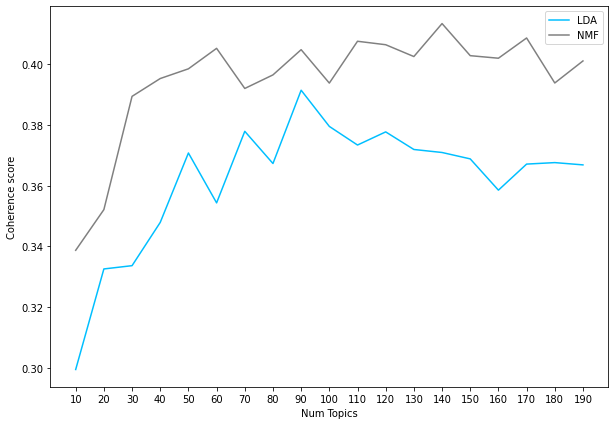

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10,7))
limit=200; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values_lda,color = "deepskyblue", label='LDA')
plt.plot(x, coherence_values_nmf,color = "gray", label='NMF')
plt.legend(loc='upper right')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x)
plt.show()

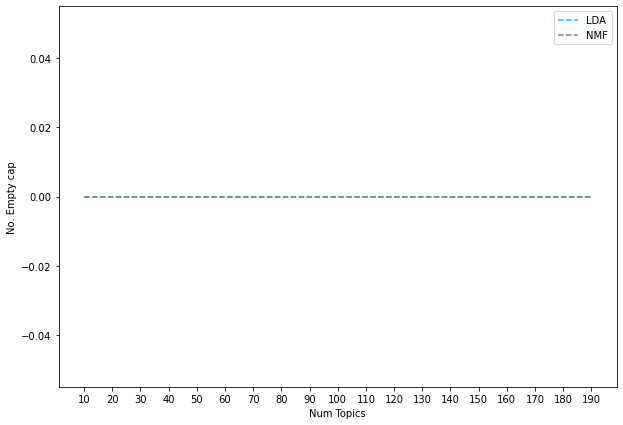

In [ ]:
figure(figsize=(10,7))
limit=200; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, empty_document_lda,color = "deepskyblue", label = 'LDA',linestyle='dashed')
plt.plot(x, empty_document_nmf,color = "gray", label = 'NMF',linestyle='dashed')
plt.xlabel("Num Topics")
plt.ylabel("No. Empty cap")
plt.legend(loc='upper right')
plt.xticks(x)
plt.show()

# 9000 samples

In [ ]:
# Select the first 1000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 5,000 examples.
train_image_paths3 = image_paths [:9000]
print(len(train_image_paths3))

9000


In [ ]:
import pandas as pd
caption_table=pd.DataFrame(list())
caption_table['image_path']=train_image_paths3
caption_table['text']=['']*9000
caption_table['image_path'][0]

'/content/train2014/COCO_train2014_000000521200.jpg'

In [ ]:
# create dataframe to store image path, with ALL CAPTION MERGED
for i in range(9000):
    caption_table['text'][i]= image_path_to_caption[list(image_path_to_caption.keys())[i]][0][8:-6]
    for j in range(1, len(image_path_to_caption[list(image_path_to_caption.keys())[i]])):
        caption_table['text'][i]=caption_table['text'][i]+ ' ' + image_path_to_caption[list(image_path_to_caption.keys())[i]][j][8:-6]

In [ ]:
import re
# Convert to list
data = caption_table['text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['A very clean and well decorated empty bathroom A blue and white bathroom with butterfly themed wall tiles. A bathroom with a border of butterflies and blue paint on the walls above it. An angled view of a beautifully decorated bathroom. A clock that blends in with the wall hangs in a bathroom. ']


In [ ]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



[['very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom', 'blue', 'and', 'white', 'bathroom', 'with', 'butterfly', 'themed', 'wall', 'tiles', 'bathroom', 'with', 'border', 'of', 'butterflies', 'and', 'blue', 'paint', 'on', 'the', 'walls', 'above', 'it', 'an', 'angled', 'view', 'of', 'beautifully', 'decorated', 'bathroom', 'clock', 'that', 'blends', 'in', 'with', 'the', 'wall', 'hangs', 'in', 'bathroom']]


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom', 'blue', 'and', 'white', 'bathroom', 'with', 'butterfly', 'themed', 'wall', 'tiles', 'bathroom', 'with', 'border', 'of', 'butterflies', 'and', 'blue', 'paint', 'on', 'the', 'walls', 'above', 'it', 'an', 'angled', 'view', 'of', 'beautifully', 'decorated', 'bathroom', 'clock', 'that', 'blends', 'in', 'with', 'the', 'wall', 'hangs', 'in', 'bathroom']


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy
import en_core_web_sm
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['well', 'decorate', 'empty', 'bathroom', 'blue', 'white', 'theme', 'tile', 'border', 'butterfly', 'blue', 'paint', 'wall', 'angle', 'view', 'beautifully', 'decorate', 'bathroom', 'clock', 'blend', 'hang']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [ ]:
coherence_values_lda = []
coherence_values_nmf = []
empty_document_lda=[]
empty_document_nmf=[]

#perplex=[]
model_list_lda = []
model_list_nmf = []
for num_topics in range(10,200,10):
    model_lda = ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_lda.append(model_lda)
    coherencemodel_lda = CoherenceModel(model=model_lda, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_lda.append(coherencemodel_lda.get_coherence())
    count_lda=0
    for i, row in enumerate(model_lda[corpus]):
        if row==[]:
            count_lda+=1
    empty_document_lda.append(count_lda)
    #perplex.append(model.log_perplexity(corpus))
    model_nmf =  nmf.Nmf(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_nmf.append(model_nmf)
    coherencemodel_nmf = CoherenceModel(model=model_nmf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_nmf.append(coherencemodel_nmf.get_coherence())
    count_nmf=0
    for i, row in enumerate(model_nmf[corpus]):
        if row==[]:
            count_nmf+=1
    empty_document_nmf.append(count_nmf)
    print (num_topics)

10
20
30
40
50
60
70
80
90


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


100


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


110


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


120


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


130


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


140


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


150


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


160


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


170


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


180


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


190


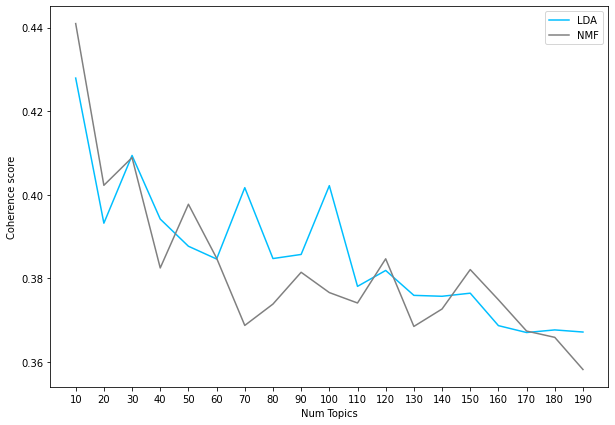

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10,7))
limit=200; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values_lda,color = "deepskyblue", label='LDA')
plt.plot(x, coherence_values_nmf,color = "gray", label='NMF')
plt.legend(loc='upper right')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x)
plt.show()

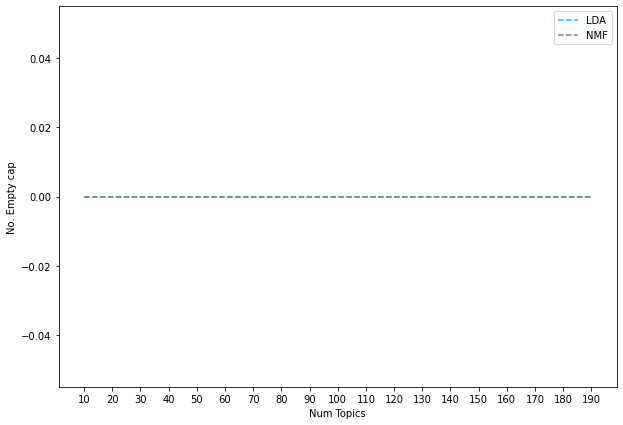

In [ ]:
figure(figsize=(10,7))
limit=200; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, empty_document_lda,color = "deepskyblue", label = 'LDA',linestyle='dashed')
plt.plot(x, empty_document_nmf,color = "gray", label = 'NMF',linestyle='dashed')
plt.xlabel("Num Topics")
plt.ylabel("No. Empty cap")
plt.legend(loc='upper right')
plt.xticks(x)
plt.show()

# 13000

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.Random(42).shuffle(image_paths)

# Select the first 1000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 5,000 examples.
train_image_paths = image_paths [:13000]
print(len(train_image_paths))

13000


In [ ]:
import pandas as pd
caption_table=pd.DataFrame(list())
caption_table['image_path']=train_image_paths
caption_table['text']=['']*13000
caption_table['image_path'][0]

'/content/train2014/COCO_train2014_000000521200.jpg'

In [ ]:
# create dataframe to store image path, with ALL CAPTION MERGED
for i in range(13000):
    caption_table['text'][i]= image_path_to_caption[caption_table['image_path'][i]][0][8:-6]
    for j in range(1, len(image_path_to_caption[caption_table['image_path'][i]])):
        caption_table['text'][i]=caption_table['text'][i]+ ' ' + image_path_to_caption[caption_table['image_path'][i]][j][8:-6]


In [ ]:
import re
# Convert to list
data = caption_table['text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['A modern sink and shower stall are visible in this photo. A white sink in a bathroom next to a wooden bench. A small sink in a tan public restoom A bathroom with a sink, shower and bench. A large bathroom has a shower and sink.']


In [ ]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



[['modern', 'sink', 'and', 'shower', 'stall', 'are', 'visible', 'in', 'this', 'photo', 'white', 'sink', 'in', 'bathroom', 'next', 'to', 'wooden', 'bench', 'small', 'sink', 'in', 'tan', 'public', 'restoom', 'bathroom', 'with', 'sink', 'shower', 'and', 'bench', 'large', 'bathroom', 'has', 'shower', 'and', 'sink']]


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['modern', 'sink', 'and', 'shower', 'stall', 'are', 'visible', 'in', 'this', 'photo', 'white', 'sink', 'in', 'bathroom', 'next', 'to', 'wooden', 'bench', 'small', 'sink', 'in', 'tan', 'public', 'restoom', 'bathroom', 'with', 'sink', 'shower', 'and', 'bench', 'large', 'bathroom', 'has', 'shower', 'and', 'sink']


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy
import en_core_web_sm
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['modern', 'sink', 'shower', 'visible', 'photo', 'white', 'sink', 'bathroom', 'wooden', 'bench', 'small', 'sink', 'public', 'bathroom', 'sink', 'shower', 'bench', 'large', 'bathroom', 'shower', 'sink']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [ ]:
pip install gensim==3.8.1

     |████████████████████████████████| 24.2 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import ldamodel
from gensim.models import nmf

In [ ]:
coherence_values_lda = []
coherence_values_nmf = []
empty_document_lda=[]
empty_document_nmf=[]

#perplex=[]
model_list_lda = []
model_list_nmf = []
for num_topics in range(10,200,10):
    model_lda = ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_lda.append(model_lda)
    coherencemodel_lda = CoherenceModel(model=model_lda, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_lda.append(coherencemodel_lda.get_coherence())
    count_lda=0
    for i, row in enumerate(model_lda[corpus]):
        if row==[]:
            count_lda+=1
    empty_document_lda.append(count_lda)
    #perplex.append(model.log_perplexity(corpus))
    model_nmf =  nmf.Nmf(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_nmf.append(model_nmf)
    coherencemodel_nmf = CoherenceModel(model=model_nmf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_nmf.append(coherencemodel_nmf.get_coherence())
    count_nmf=0
    for i, row in enumerate(model_nmf[corpus]):
        if row==[]:
            count_nmf+=1
    empty_document_nmf.append(count_nmf)
    print (num_topics)

10
20
30
40
50
60
70
80
90


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


100


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


110


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


120


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


130


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


140


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


150


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


160


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


170


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


180


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


190


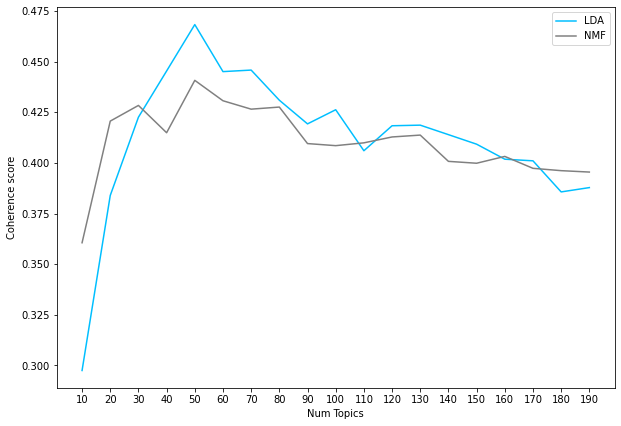

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10,7))
limit=200; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values_lda,color = "deepskyblue", label='LDA')
plt.plot(x, coherence_values_nmf,color = "gray", label='NMF')
plt.legend(loc='upper right')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x)
plt.show()

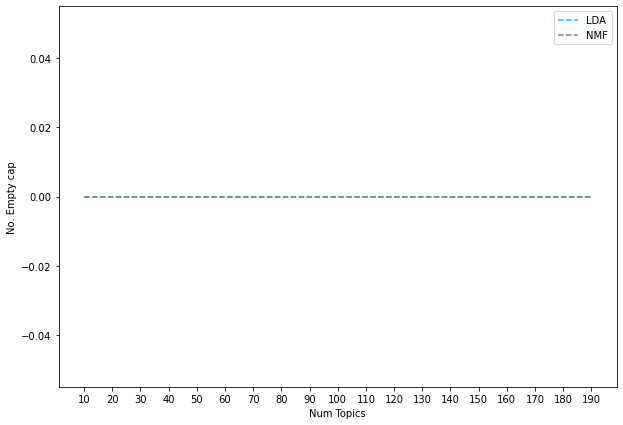

In [ ]:
figure(figsize=(10,7))
limit=200; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, empty_document_lda,color = "deepskyblue", label = 'LDA',linestyle='dashed')
plt.plot(x, empty_document_nmf,color = "gray", label = 'NMF',linestyle='dashed')
plt.xlabel("Num Topics")
plt.ylabel("No. Empty cap")
plt.legend(loc='upper right')
plt.xticks(x)
plt.show()